<a href="https://colab.research.google.com/github/dtabuena/Workshop/blob/main/Ripples.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
'Get Standard Modules'

import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import scipy
from scipy import stats
import os
from scipy.signal import butter,filtfilt
from tqdm import tqdm
import warnings
from IPython.display import clear_output
from datetime import datetime
import sys
import warnings
import shutil
from google import colab
from tqdm import tqdm
import h5py

warnings.filterwarnings('ignore')
np.set_printoptions(threshold=sys.maxsize)
clear_output(wait=False)



!pip install openpyxl
!pip install XlsxWriter
!pip install --upgrade pyabf
import pyabf


clear_output()


In [80]:
def get_drobox_folder(link, new_filename):
    'Download a folder from dropbox and unzip'
    zipped_file_path = "/content/"+new_filename + ".zip"
    unzipped_file_path = "/content/"+new_filename
    if not( os.path.exists(zipped_file_path)):
        !wget -O $zipped_file_path $link    # download with new name
    # if not( os.path.exists(new_filename_stripped)):
    !echo A | unzip $zipped_file_path -d $unzipped_file_path
    return new_filename



####### MATH
def z_trans_2(x):
    x_mean = np.expand_dims(np.mean(x,axis=1),1)
    x_std = np.expand_dims(np.std(x,axis=1),1)
    x_z = (x - x_mean) / x_std
    return x_z

def z_trans(x):
    x_mean = np.mean(x)
    x_std = np.std(x)
    x_z = (x - x_mean) / x_std
    return x_z

def mov_mean(x,stride):
    x_mm = np.convolve(x,np.ones(stride),'same')/stride
    return x_mm



def inspect_trace(trace,time,fs,line_length=10,start_stop=[],z_scale=6,single_trace_plot_size=[18,2],figax_prev=False,spec_color=False):
    ''' waterfall plot of trace '''


    if len(start_stop) <2: start_stop=[time[0],time[-1]]
    time_bool = np.logical_and(time>=start_stop[0],time<start_stop[-1])
    time =np.round(time,6)
    time = time[time_bool]
    trace = trace[time_bool]



    # max_t_adj =  np.ceil(start_stop[1]/line_length)*line_length
    # pad_width =  int(fs*(max_t_adj) - len(time))


    delta_t = time[-1]-time[0]
    num_lines = int(np.ceil(delta_t/line_length))
    pad_width = num_lines*line_length*fs - len(time)

    print(delta_t,num_lines,pad_width)

    if pad_width > 0:
        pad_trace = np.pad(trace,((0,pad_width)),constant_values=(np.nan,np.nan))
        pad_time =  np.pad(time,pad_width,'constant',constant_values=(np.nan,np.nan))
    else:
        pad_time=time
        pad_trace =trace

    tics_per_line = int(fs*line_length)
    pad_trace_stack = np.reshape(pad_trace,[num_lines,tics_per_line])

    line_time = np.arange(tics_per_line)/fs
    line_time_stack = np.resize(line_time,[num_lines,tics_per_line] )



    y_adjust_const = np.std(trace)*z_scale
    y_adj = y_adjust_const * (np.cumsum(np.ones_like(pad_trace_stack)*-1,axis=0)+1)

    if not figax_prev:
        plt.rcParams["axes.prop_cycle"] = plt.cycler("color", np.flip(plt.cm.viridis(np.linspace(0,1,10)),axis=0))
        fig,ax=plt.subplots(figsize=(single_trace_plot_size[0],single_trace_plot_size[1]*num_lines))
    else: (fig,ax) = figax_prev

    if not spec_color: ax.plot(line_time_stack.T,(pad_trace_stack+y_adj).T)
    else: ax.plot(line_time_stack.T,(pad_trace_stack+y_adj).T,color = spec_color)

    ax.set_xlim(line_time[0],line_time[-1])

    from matplotlib.ticker import MultipleLocator
    ax.yaxis.set_minor_locator(MultipleLocator(z_scale/2))

    return fig,ax

def time_bands(abf,sweepNumber=0,channel=0,order = 4,blank_time=4,new_fs = 1250):
    fs = int(abf.sampleRate)
    abf.setSweep(sweepNumber=sweepNumber,channel=channel)
    v_trace = abf.sweepY
    time = abf.sweepX

    new_fs = int(new_fs)

    # interp_func = scipy.interpolate.interp1d(time, v_trace, kind='linear')
    # time_1khz = np.arange(0,time[-1]+1/fs,1/new_fs)
    # time_1khz = time_1khz[np.logical_and(time_1khz>=time[0],time_1khz<=time[-1])]
    # v_trace_1khz = interp_func(time_1khz)


    ds_factor = int(np.ceil(fs/new_fs))
    ds_factor = int(ds_factor)
    v_trace_1khz = v_trace[::ds_factor]
    time_1khz = time[::ds_factor]
    nyq = new_fs/2

    if np.max(time_1khz)<blank_time:
        freq_bands = {'fs':np.nan,
                  'time_1khz':{'lfp':np.nan,'hilb_env':np.nan},
                  'full_band':{'lfp':np.nan,'hilb_env':np.nan},
                  'wide_band':{'lfp':np.nan,'hilb_env':np.nan},
                  'sharp_wave_band':{'lfp':np.nan,'hilb_env':np.nan},
                  'ripple_band':{'lfp':np.nan,'hilb_env':np.nan},
                  'slow_gamma_band':{'lfp':np.nan,'hilb_env':np.nan},
                  }
        return freq_bands

    v_trace_1khz[np.arange(0,blank_time*fs)] = v_trace_1khz[blank_time*fs]

    sos = scipy.signal.butter(order, [0.7,600], btype='bandpass',fs=new_fs,output='sos')
    wide_band = scipy.signal.sosfiltfilt(sos, v_trace_1khz)

    sos = scipy.signal.butter(order, [120,250], btype='bandpass',fs=new_fs,output='sos')
    ripple_band = scipy.signal.sosfiltfilt(sos, wide_band)

    sos = scipy.signal.butter(order, [15 ,50], btype='bandpass',fs=new_fs,output='sos')
    slow_gamma_band = scipy.signal.sosfiltfilt(sos, wide_band)

    # b, a = scipy.signal.butter(order, [1 ,20], btype='bandpass',fs=new_fs)
    # sharp_wave_band = scipy.signal.filtfilt(b, a, wide_band)
    sos = scipy.signal.butter(order, [1 ,20], btype='bandpass',fs=new_fs,output='sos')
    sharp_wave_band = scipy.signal.sosfiltfilt(sos, wide_band)

    sos = scipy.signal.butter(order, [250 ,600], btype='bandpass',fs=new_fs,output='sos')
    fast_ripple_band = scipy.signal.sosfiltfilt(sos, v_trace_1khz)

    freq_bands = {'fs':new_fs,
                  'time_1khz':time_1khz,
                  'full_band':v_trace_1khz,
                  'wide_band':wide_band,
                  'sharp_wave_band':sharp_wave_band,
                  'ripple_band':ripple_band,
                  'fast_ripple_band':fast_ripple_band,
                  'slow_gamma_band':slow_gamma_band,
                  }

    for k in freq_bands.keys():
        if 'band' in k:
                amplitude_envelope = np.abs(scipy.signal.hilbert(freq_bands[k]))
                amplitude_envelope[np.arange(0,blank_time*fs)] = amplitude_envelope[blank_time*fs]
                freq_bands[k] = {'lfp': freq_bands[k], 'hilb_env':amplitude_envelope}

    return freq_bands



def get_waveforms_stack(waveform,trigs,fs,window_ms=[-150,150]):
    window_s = np.array(window_ms)/fs
    window_tics = np.arange(window_ms[0]/1000*fs,window_ms[1]/1000*fs,1,dtype=int)
    window_time = window_tics/fs
    wave_snip_list = []
    for t in trigs:
        try: wave_snip_list.append(waveform[t+window_tics])
        except: None
    wave_snip_stack = np.stack(wave_snip_list,axis=-1)
    return wave_snip_stack, window_time

def quick_wavelet(trace,fs,bottom_freq=1,top_freq = False,num_freq_bins=40,log_freq=False):
    if not top_freq: top_freq = fs/2
    if log_freq:
        freqs = np.logspace(np.log2(bottom_freq), np.log2(top_freq), num=num_freq_bins, endpoint=True, base=2)
    else:
        freqs=np.linspace(bottom_freq,top_freq,num=num_freq_bins )
    # w =3
    # widths = w*fs / (2*freqs*np.pi)
    # print(widths)
    # cwt_morlet = scipy.signal.cwt(trace, scipy.signal.morlet2, widths, w=w)
    # print(scipy.signal.morlet2.shape)



    w = 6.
    widths = w*fs / (2*freqs*np.pi)
    cwt_morlet = scipy.signal.cwt(trace, scipy.signal.morlet2, widths,dtype='complex64' )

    print(cwt_morlet[:,80000])

    cwt_abs = np.abs(cwt_morlet)
    print(cwt_abs[:,80000])

    cwt_mean = np.expand_dims(np.mean(cwt_abs,axis=1),-1)
    cwt_std = np.expand_dims(np.std(cwt_abs,axis=1),-1)
    cwt_z = (cwt_abs - cwt_mean) / cwt_std


    log_ticks = np.floor(np.log2(freqs))
    log_ticks = np.arange(log_ticks[0],log_ticks[-1]+1,1)
    log_ticks = np.exp2(log_ticks)

    cwt_results =  {'cwt_z':cwt_z,'freqs':freqs,'cwt_mean':cwt_mean,'cwt_std':cwt_std,'log_ticks':log_ticks}
    return cwt_results



def get_wavelet_stack(wavelet,trigs,fs,window_ms=[-150,150]):
    window_s = np.array(window_ms)/fs
    window_tics = np.arange(window_ms[0]/1000*fs,window_ms[1]/1000*fs,1,dtype=int)
    window_time = window_tics/fs
    wavelet_snip_list = []
    for t in trigs:
        try: wavelet_snip_list.append(wavelet[:,t+window_tics])
        except: None
    wavelet_snip_list = np.stack(wavelet_snip_list,axis=-1)
    return wavelet_snip_list, window_time



def event_properties(waveform,trigs,fs=1000,window_ms=[-150,150]):
    wave_snip_stack, window_time = get_waveforms_stack(waveform,trigs,fs,window_ms=[-150,150])
    waveform_hilb_env = np.abs(scipy.signal.hilbert(waveform))
    wave_snip_stack_hilb, window_time = get_waveforms_stack(waveform_hilb_env,trigs,fs,window_ms=[-150,150])
    waveform_z_power = z_trans(waveform_hilb_env)

    events_df = pd.DataFrame(index=np.arange(wave_snip_stack.shape[1]))
    events_df['trig_ind'] = trigs
    events_df['trig_time'] = trigs/fs
    events_df['peak_amp'] = np.max(wave_snip_stack,axis=0)
    events_df['min_amp'] = np.min(wave_snip_stack,axis=0)
    events_df['tot_hilb'] = np.sum(wave_snip_stack_hilb,axis=0)
    events_df['peak_z_power'] = np.max(waveform_z_power,axis=0)
    return events_df



In [ ]:

# display( event_properties(waveform,trigs).head(20))

In [3]:
data_source = "https://www.dropbox.com/sh/cz03im6sa98nquz/AAB-WXnlE4jdTp37CiwVPUCLa?dl=0"
data_name = 'rip_data'
file_loc = get_drobox_folder(data_source, data_name)
file_list = []
for (root, dirs, file) in os.walk(file_loc):
    for f in file:
        if ".abf" in f:
            file_list.append(os.path.join(root,f))
clear_output()

file_list = []
# dates_to_analyze = ['2023x07x06','2023x07x07_E3KI','2023x07x13','2023x07x12','2023x07x14','2023x07x17','2023x07x20','2023x07x21']
dates_to_analyze = ['2023x07x27']
for (rt,dr,files) in os.walk('/content/rip_data/'):
    for f in files:
        for d in dates_to_analyze:
            if d in f and '.abf' in f[-4:]:
                file_list.append(os.path.join(rt,f))

file_list.sort()
clear_output()
print(len(file_list))

2


In [32]:
######### Process Good Recs #########


e4_79_good_list = ['/content/rip_data/2023x07x27/2023x07x27_E4KI_F_P296_s1x2_0000.abf',
                   '/content/rip_data/2023x07x27/2023x07x27_E4KI_F_P296_s3x4_0000.abf',
                   '/content/rip_data/2023x07x21/2023x07x21_E4KI_F_P290_s1x2_0001.abf',
                   '/content/rip_data/2023x07x21/2023x07x21_E4KI_F_P290_s7x8_0002.abf',
                   '/content/rip_data/2023_07_17/2023x07x17_E4KI_F_P286_s2x3_0001.abf',
                   '/content/rip_data/2023_07_17/2023x07x17_E4KI_F_P286_s4x5_0000.abf',
                   '/content/rip_data/2023_07_17/2023x07x17_E4KI_F_P286_s4x5_0001.abf']


e4_79_spike_list = ['/content/rip_data/2023x07x21/2023x07x21_E4KI_F_P290_s3x4_0000.abf',
                    '/content/rip_data/2023x07x21/2023x07x21_E4KI_F_P290_s5x6_0000.abf',
                    '/content/rip_data/2023_07_17/2023x07x17_E4KI_F_P286_s001_0001.abf']

e3_79_good_list = ['/content/rip_data/2023_07_14/2023x07x14_E3KI_F_P279_s001_0001.abf',
                   '/content/rip_data/2023_07_14/2023x07x14_E3KI_F_P279_s2x3_0001.abf',
                   '/content/rip_data/2023_07_14/2023x07x14_E3KI_F_P279_s2x3_0003.abf',
                   '/content/rip_data/2023_07_14/2023x07x14_E3KI_F_P279_s4x5_0000.abf',
                   '/content/rip_data/2023_07_14/2023x07x14_E3KI_F_P279_s4x5_0001.abf',
                   '/content/rip_data/2023_07_14/2023x07x14_E3KI_F_P279_s6x7_0002.abf',
                   '/content/rip_data/2023_07_14/2023x07x14_E3KI_F_P279_s6x7_0003.abf',
                   ]

### Concat Lists for Bulk Analysis###
full_79_file_list=e4_79_good_list+e4_79_spike_list+e3_79_good_list
rip_df_79 = pd.DataFrame(index=full_79_file_list)
chan_list = ['ch_0','ch_1']
for c in chan_list:
    rip_df_79[c]=np.nan
    rip_df_79[c] = rip_df_79[c].astype('object')

# for f in rip_df_79.index:
#     row_series = (rip_df_79.loc[f]).to_frame().transpose()
#     hdf_fold = '/content/hdf_files'
#     try: os.makedirs(hdf_fold)
#     except: None
#     key_f = f.replace('/',"")
#     hdf_path = hdf_fold+'/'+os.path.basename(f)[:-4] +'.h5'
#     row_series.to_hdf(hdf_path,key=key_f)

# ###  Generate time series filters ###
# for f in tqdm( rip_df_79.index ):
#     key_f = f.replace('/',"")
#     hdf_path = hdf_fold+'/'+os.path.basename(f)[:-4]+'.h5'
#     rec_entry = pd.read_hdf(hdf_path,key=key_f)

#     abf = pyabf.ABF(f)
#     blank_time=5
#     for ch in chan_list:
#         rec_entry.at[f,ch] = time_bands(abf,sweepNumber=0,channel= chan_list.index(ch) ,blank_time=blank_time,new_fs=2500)

#     rec_entry.to_hdf(hdf_path,key=key_f)


In [46]:
### Concat Lists for Bulk Analysis###
full_79_file_list=e4_79_good_list+e4_79_spike_list+e3_79_good_list
rip_df_79 = pd.DataFrame(index=full_79_file_list)
chan_list = ['ch_0','ch_1']
for c in chan_list:
    rip_df_79[c]=np.nan
    rip_df_79[c] = rip_df_79[c].astype('object')



for ch in chan_list:
    for band in trig_bands:
        rip_df_79[(ch,band+'_trigs')]=np.nan
        rip_df_79[(ch,band+'_trigs')]=rip_df_79[(ch,band+'_trigs')].astype('object')
        rip_df_79[(ch,band+'_trig_rate')] =np.nan

# display(rip_df_79.head(20))

#### all_in_one ####

for f in tqdm( rip_df_79.index ):
    # key_f = f.replace('/',"")
    # hdf_path = hdf_fold+'/'+os.path.basename(f)[:-4]+'.h5'
    # rec_entry = pd.read_hdf(hdf_path,key=key_f)

    abf = pyabf.ABF(f)
    for ch in chan_list:
        filtered = time_bands(abf,sweepNumber=0,channel= chan_list.index(ch) ,blank_time=blank_time,new_fs=2500)
        for b in trig_bands:
            trace = filtered[b]['hilb_env']
            fs = filtered['fs']
            trigs = triggered_inds(trace,fs,min_dur_ms=10)
            filtered[b]['trigs'] = trigs
            # rec_entry.at[f,ch] = filtered
            # rec_entry.to_hdf(hdf_path,key=key_f)
            rip_df_79.at[f,(ch,band+'_trigs')] = trigs
            if len(trigs)>1:
                trig_rate = len(trigs)/((trigs[-1]-trigs[0])/fs)
            else: trig_rate= np.nan
            rip_df_79.at[f,(ch,band+'_trig_rate')] = trig_rate

  0%|          | 0/17 [00:00<?, ?it/s]

[2500.]
[2500.]


  6%|▌         | 1/17 [01:42<27:18, 102.39s/it]

[2500.]
[2500.]


 12%|█▏        | 2/17 [02:10<14:39, 58.61s/it] 

[2500.]
[2500.]


 18%|█▊        | 3/17 [02:56<12:18, 52.78s/it]

[2500.]
[2500.]


 24%|██▎       | 4/17 [03:28<09:39, 44.59s/it]

[2500.]
[2500.]


 29%|██▉       | 5/17 [04:29<10:06, 50.54s/it]

[2500.]
[2500.]


 35%|███▌      | 6/17 [04:44<07:04, 38.59s/it]

[2500.]
[2500.]


 41%|████      | 7/17 [04:51<04:41, 28.15s/it]

[2500.]
[2500.]


 47%|████▋     | 8/17 [05:05<03:33, 23.76s/it]

[2500.]
[2500.]


 53%|█████▎    | 9/17 [05:28<03:07, 23.49s/it]

[2500.]
[2500.]


 59%|█████▉    | 10/17 [07:06<05:25, 46.45s/it]

[2500.]
[2500.]


 65%|██████▍   | 11/17 [07:19<03:37, 36.24s/it]

[2500.]
[2500.]


 71%|███████   | 12/17 [07:26<02:17, 27.44s/it]

[2500.]
[2500.]


 76%|███████▋  | 13/17 [07:38<01:30, 22.65s/it]

[2500.]
[2500.]


 82%|████████▏ | 14/17 [08:19<01:24, 28.24s/it]

[2500.]
[2500.]


 88%|████████▊ | 15/17 [08:28<00:44, 22.26s/it]

[2500.]
[2500.]


 94%|█████████▍| 16/17 [08:42<00:19, 19.79s/it]

[2500.]
[2500.]


100%|██████████| 17/17 [09:01<00:00, 31.87s/it]


In [41]:
display(rip_df_79.head(5))

,ch_0,ch_1,"(ch_0, ripple_band_trigs)","(ch_0, sharp_wave_band_trigs)","(ch_0, slow_gamma_band_trigs)","(ch_1, ripple_band_trigs)","(ch_1, sharp_wave_band_trigs)","(ch_1, slow_gamma_band_trigs)","(/content/rip_data/2023_07_14/2023x07x14_E3KI_F_P279_s6x7_0003.abf, (ch_0, ripple_band_trig_rate))","(/content/rip_data/2023_07_14/2023x07x14_E3KI_F_P279_s6x7_0003.abf, (ch_0, sharp_wave_band_trig_rate))",...,"(/content/rip_data/2023_07_14/2023x07x14_E3KI_F_P279_s6x7_0003.abf, (ch_1, sharp_wave_band_trig_rate))","(/content/rip_data/2023_07_14/2023x07x14_E3KI_F_P279_s6x7_0003.abf, (ch_1, slow_gamma_band_trig_rate))","(/content/rip_data/2023x07x27/2023x07x27_E4KI_F_P296_s1x2_0000.abf, (ch_0, ripple_band_trig_rate))","(/content/rip_data/2023x07x27/2023x07x27_E4KI_F_P296_s1x2_0000.abf, (ch_0, sharp_wave_band_trig_rate))","(/content/rip_data/2023x07x27/2023x07x27_E4KI_F_P296_s1x2_0000.abf, (ch_0, slow_gamma_band_trig_rate))","(/content/rip_data/2023x07x27/2023x07x27_E4KI_F_P296_s1x2_0000.abf, (ch_1, ripple_band_trig_rate))","(/content/rip_data/2023x07x27/2023x07x27_E4KI_F_P296_s1x2_0000.abf, (ch_1, sharp_wave_band_trig_rate))","(/content/rip_data/2023x07x27/2023x07x27_E4KI_F_P296_s1x2_0000.abf, (ch_1, slow_gamma_band_trig_rate))",slow_gamma_band_trigs,slow_gamma_band_trig_rate
/content/rip_data/2023x07x27/2023x07x27_E4KI_F_P296_s1x2_0000.abf,0.456482,0.517142,NaN,NaN,"[25967, 28129, 31757, 35818, 37864, 43216, 538...",NaN,NaN,"[12, 29593, 33867, 37164, 45614, 51321, 54566,...",NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.517142
/content/rip_data/2023x07x27/2023x07x27_E4KI_F_P296_s3x4_0000.abf,0.456482,0.517142,NaN,NaN,"[25967, 28129, 31757, 35818, 37864, 43216, 538...",NaN,NaN,"[12, 29593, 33867, 37164, 45614, 51321, 54566,...",NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.517142
/content/rip_data/2023x07x21/2023x07x21_E4KI_F_P290_s1x2_0001.abf,0.456482,0.517142,NaN,NaN,"[25967, 28129, 31757, 35818, 37864, 43216, 538...",NaN,NaN,"[12, 29593, 33867, 37164, 45614, 51321, 54566,...",NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.517142
/content/rip_data/2023x07x21/2023x07x21_E4KI_F_P290_s7x8_0002.abf,0.456482,0.517142,NaN,NaN,"[25967, 28129, 31757, 35818, 37864, 43216, 538...",NaN,NaN,"[12, 29593, 33867, 37164, 45614, 51321, 54566,...",NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.517142
/content/rip_data/2023_07_17/2023x07x17_E4KI_F_P286_s2x3_0001.abf,0.456482,0.517142,NaN,NaN,"[25967, 28129, 31757, 35818, 37864, 43216, 538...",NaN,NaN,"[12, 29593, 33867, 37164, 45614, 51321, 54566,...",NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.517142


In [19]:
#### Zip and DL ###
def zip_and_dl(folder):
    zip_name = folder+'.zip'
    !zip -r $zip_name $folder
    colab.files.download(zip_name)
zip_and_dl('/content/hdf_files')

  adding: content/hdf_files/ (stored 0%)
  adding: content/hdf_files/2023x07x21_E4KI_F_P290_s1x2_0001.h5 (deflated 29%)
  adding: content/hdf_files/2023x07x17_E4KI_F_P286_s4x5_0001.h5 (deflated 30%)
  adding: content/hdf_files/2023x07x27_E4KI_F_P296_s3x4_0000.h5 (deflated 30%)
  adding: content/hdf_files/2023x07x14_E3KI_F_P279_s001_0001.h5 (deflated 30%)
  adding: content/hdf_files/2023x07x27_E4KI_F_P296_s1x2_0000.h5 (deflated 29%)
  adding: content/hdf_files/2023x07x21_E4KI_F_P290_s7x8_0002.h5 (deflated 29%)
  adding: content/hdf_files/2023x07x21_E4KI_F_P290_s5x6_0000.h5 (deflated 30%)
  adding: content/hdf_files/2023x07x14_E3KI_F_P279_s2x3_0001.h5 (deflated 30%)
  adding: content/hdf_files/2023x07x14_E3KI_F_P279_s4x5_0000.h5 (deflated 29%)
  adding: content/hdf_files/2023x07x14_E3KI_F_P279_s6x7_0003.h5 (deflated 29%)
  adding: content/hdf_files/2023x07x14_E3KI_F_P279_s6x7_0002.h5 (deflated 30%)
  adding: content/hdf_files/2023x07x14_E3KI_F_P279_s2x3_0003.h5 (deflated 29%)
  adding: c

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [21]:
#### Triggs ###

def triggered_inds(trace,fs,sd_thresh= 3,min_dur_ms= 5,peak_wind_ms=20):
    ''' trigger on crossing'''
    trig_bool = z_trans(trace)>sd_thresh
    min_dur_tic = int(min_dur_ms*fs/1000)
    trig_bool = mov_mean(trig_bool,min_dur_tic)==1
    trigs = np.arange(len(trig_bool))[np.diff(trig_bool,prepend=0)==1]

    ''' allign peaks'''
    tick_range = peak_wind_ms/1000*fs
    peak_window_tics = np.arange(0,tick_range,dtype=int)
    trig_alligned = []
    max_tick = len(trace)
    for t in trigs:
        if (t+peak_window_tics[0])>=0 and (t+peak_window_tics[-1])<max_tick:
            sub_trace = trace[t+peak_window_tics]
            peak_tick = np.where(sub_trace==np.max(sub_trace))[0][0]
            trig_alligned.append(t+peak_tick-np.min(peak_window_tics))
    trig_alligned=np.array(trig_alligned)

    return trig_alligned


trig_bands = ['ripple_band','sharp_wave_band','slow_gamma_band']

for f in tqdm( rip_df_79.index ):
    key_f = f.replace('/',"")
    hdf_path = hdf_fold+'/'+os.path.basename(f)[:-4]+'.h5'
    rec_entry = pd.read_hdf(hdf_path,key=key_f)
    for ch in chan_list:
        filtered = rec_entry.loc[f,ch]
        for b in trig_bands:
            trace = filtered[b]['hilb_env']
            fs = filtered['fs']
            trigs = triggered_inds(trace,fs,min_dur_ms=10)
            filtered[b]['trigs'] = trigs
        rec_entry.at[f,ch] = filtered
        rec_entry.to_hdf(hdf_path,key=key_f)




100%|██████████| 17/17 [06:03<00:00, 21.36s/it]


In [ ]:
### Match Recs and Notes
rip_notes = pd.read_csv('/content/rip_data/Ripples - Sheet1.csv') # .set_index('Slice_Code')
keep_rows = []
for r in rip_notes.index:
    sl = str(rip_notes.loc[r,'Slice_Code'])
    check_slice = any([sl in f for f in file_list])
    if check_slice: keep_rows.append(True)
    else: keep_rows.append(False)
rip_notes = rip_notes[keep_rows]


for r in rip_notes.index:
    sl = rip_notes.loc[r,'Slice_Code']
    number =rip_notes.loc[r,'rec']
    if not np.isnan(number):    rec_str = f"{int(number):04d}"
    else:    rec_str = 'nan'
    slice_code_plus = sl+ '_' + rec_str
    rip_notes.at[r,'slice_code_plus']=slice_code_plus
rip_notes = rip_notes.set_index('slice_code_plus')



rip_df = pd.DataFrame(index=file_list)

chan_list = ['ch_0','ch_1']
for c in chan_list:
    rip_df[c]=np.nan
    rip_df[c] = rip_df[c].astype('object')



for f in rip_df.index:
    f_slice = os.path.basename(f)[:-4]
    if f_slice in rip_notes.index:
        # print(f_slice)
        # print(rip_notes.loc[f_slice,'epoch_0'])
        rip_df.at[f,'epoch_0'] = rip_notes.loc[f_slice,'epoch_0']
        rip_df.at[f,'epoch_1'] = rip_notes.loc[f_slice,'epoch_1']


rip_df_keep = []
for f in rip_df.index:
    f_slice = os.path.basename(f)[:-4]
    rip_df_keep.append(f_slice in rip_notes.index)
rip_df=rip_df[rip_df_keep]


### convert to HDF
for f in rip_df.index:
    row_series = (rip_df.loc[f]).to_frame().transpose()
    hdf_fold = '/content/hdf_files'
    try: os.makedirs(hdf_fold)
    except: None
    key_f = f.replace('/',"")
    hdf_path = hdf_fold+'/'+os.path.basename(f)[:-4] +'.h5'
    row_series.to_hdf(hdf_path,key=key_f)



In [ ]:
def zip_and_dl(folder):
    zip_name = folder+'.zip'
    !zip -r $zip_name $folder
    colab.files.download(zip_name)
# zip_and_dl('/content/hdf_files')

In [ ]:
# zip_and_dl('/content/hdf_files')

In [ ]:
def triggered_inds(trace,fs,sd_thresh= 3,min_dur_ms= 5,peak_wind_ms=20):
    ''' trigger on crossing'''
    trig_bool = z_trans(trace)>sd_thresh
    min_dur_tic = int(min_dur_ms*fs/1000)
    trig_bool = mov_mean(trig_bool,min_dur_tic)==1
    trigs = np.arange(len(trig_bool))[np.diff(trig_bool,prepend=0)==1]

    ''' allign peaks'''
    tick_range = peak_wind_ms/1000*fs
    peak_window_tics = np.arange(0,tick_range,dtype=int)
    trig_alligned = []
    max_tick = len(trace)
    for t in trigs:
        if (t+peak_window_tics[0])>=0 and (t+peak_window_tics[-1])<max_tick:
            sub_trace = trace[t+peak_window_tics]
            peak_tick = np.where(sub_trace==np.max(sub_trace))[0][0]
            trig_alligned.append(t+peak_tick-np.min(peak_window_tics))
    trig_alligned=np.array(trig_alligned)

    return trig_alligned





trig_bands = ['ripple_band','sharp_wave_band','slow_gamma_band']

for f in tqdm( rip_df.index ):
    key_f = f.replace('/',"")
    hdf_path = hdf_fold+'/'+os.path.basename(f)[:-4]+'.h5'
    rec_entry = pd.read_hdf(hdf_path,key=key_f)
    for ch in chan_list:
        filtered = rec_entry.loc[f,ch]
        for b in trig_bands:
            trace = filtered[b]['hilb_env']
            fs = filtered['fs']
            trigs = triggered_inds(trace,fs)
            filtered[b]['trigs'] = trigs
            # print(len(trigs))
        rec_entry.at[f,ch] =filtered
        rec_entry.to_hdf(hdf_path,key=key_f)



# IIS_bands = ['wide_band']
# for f in tqdm( rip_df.index ):
#     key_f = f.replace('/',"")
#     hdf_path = hdf_fold+'/'+os.path.basename(f)[:-4]+'.h5'
#     rec_entry = pd.read_hdf(hdf_path,key=key_f)
#     if len(rec_entry.keys())==0:continue
#     for ch in chan_list:
#         filtered = rec_entry.loc[f,ch]
#         for b in IIS_bands:
#             amplitude_envelope = np.abs(scipy.signal.hilbert(filtered[b]['lfp']))
#             amplitude_envelope[np.arange(0,blank_time*fs)] = amplitude_envelope[blank_time*fs]
#             trace = amplitude_envelope
#             fs = filtered['fs']
#             trigs = triggered_inds(trace,fs,sd_thresh = 15)
#             filtered[b]['trigs'] = trigs
#             # print(len(trigs))
#         rec_entry.at[f,ch] =filtered
#         rec_entry.to_hdf(hdf_path,key=key_f)


In [ ]:
band = 'slow_gamma_band'

waveform = filtered[band]['lfp']
time = filtered['time_1khz']
fig,ax = inspect_trace(waveform,time,z_scale=9,single_trace_plot_size=[10,2],spec_color='k')
figax_prev= [fig,ax.twinx()]
inspect_trace(filtered[band]['hilb_env'],time,z_scale=9,single_trace_plot_size=[10,2],figax_prev=figax_prev,spec_color='r')
# for a in z[ax, ax2]:
ax.set_xlim(0,3)
ax.grid(visible=True, which='both', axis='both')


In [ ]:


def summarize_trigs(filtered,trig_bands,window_ms=[-120,120]):
    fig,ax = plt.subplots(3,3,figsize=[10,10])
    for b in trig_bands:
        bi = trig_bands.index(b)
        trigs = filtered[b]['trigs']
        for bb in trig_bands:
            bbi = trig_bands.index(bb)
            waveform = filtered[bb]['lfp']
            fs = filtered['fs']
            wave_snip_stack,window_time = get_waveforms_stack(waveform,trigs,fs,window_ms=window_ms)
            ax[bi,bbi].plot(window_time, wave_snip_stack,'grey')
            ax[bi,bbi].plot(window_time, np.mean(wave_snip_stack,1),'r')
            ax[bi,bbi].set_title(f'{bb} \n triggered from \n {b}')
# summarize_trigs(filtered,trig_bands,window_ms=[-120,120])
# plt.tight_layout()


In [ ]:
# #### Abundance over Time #######
# bin_wid =15

# for f in rip_df.index:
#     fig,ax=plt.subplots(3,figsize=(16,6))
#     fig.suptitle(os.path.basename(f))
#     for ch in chan_list:
#         filtered = rip_df.loc[f,ch]
#         for b in trig_bands:
#             ai = trig_bands.index(b)
#             trigs = filtered[b]['trigs']
#             time_1khz = filtered['time_1khz']
#             ep_0_inds =  rip_df.loc[f,'ep_0_inds']
#             epoch_time = time_1khz - time_1khz[ep_0_inds[-1]]
#             bottom_epo_time = np.floor(np.min(epoch_time)/bin_wid)*bin_wid
#             top_epo_time = np.ceil(np.max(epoch_time)/bin_wid)*bin_wid
#             bins = np.arange(bottom_epo_time,top_epo_time ,bin_wid)
#             t_hist,bin_edges = np.histogram(epoch_time[trigs], bins=bins)
#             numt = len(trigs)
#             # ax.bar(bin_edges[:-1],t_hist/bin_wid,label=f"{b}_{ch} ({numt})",width=8,)
#             ax[ai].plot(bin_edges[:-1],t_hist/bin_wid,'-o',label=f"{b}_{ch} ({numt})",)
#             ax[ai].legend(loc='upper left',bbox_to_anchor=(1, 1, 1, 0))



In [ ]:


# abf = pyabf.ABF('/content/Bumet_ephys_data/2023x07x06_E3KI_F_P525_s3x4_0000.abf')
# freq_bands = time_bands(abf,sweepNumber=0,channel=0)


def plot_abund_ts(time_1khz,trigs,bin_wid=10):
    fig,ax=plt.subplots(1,figsize=(16,4))
    bins = np.arange(0,np.max(time_1khz)+bin_wid,bin_wid)
    hist,edges = np.histogram(time_1khz[trigs], bins=bins)
    ax.bar(bins[1:],hist/bin_wid,width=bin_wid)
    ax.set_ylabel('SW abundance (Hz)')
    plt.show()
    return fig, ax


# trigs_alligned, fig, ax = get_SW_trig_inds(sharp_wave_band,fs,sw_thresh=-4,to_plot=True)

In [ ]:
# # from scipy import signal





# fs = 10000
# w = 6.
# top_freq = fs/2
# top_freq = 600
# freq = np.linspace(1, top_freq, 100)
# freq = np.logspace(np.log2(10), np.log2(top_freq), num=40, endpoint=True, base=2)
# widths = w*fs / (2*freq*np.pi)
# cwtm = scipy.signal.cwt(in0, scipy.signal.morlet2, widths, w=w)

# cw_abs = np.abs(cwtm)
# cw_mean = np.expand_dims(np.mean(cw_abs,axis=1),-1)
# cw_std = np.expand_dims(np.std(cw_abs,axis=1),-1)
# cw_z = (cw_abs - cw_mean) / cw_std





In [ ]:
""" Parse Epochs """
for f in tqdm( rip_df.index ):
    key_f = f.replace('/',"")
    hdf_path = hdf_fold+'/'+os.path.basename(f)[:-4]+'.h5'
    rec_entry = pd.read_hdf(hdf_path,key=key_f)


    epoch_list = ['ep_0_inds','ep_1_inds']
    for e in epoch_list:
        rec_entry[e] = np.nan
        rec_entry[e] = rec_entry[e].astype('object')

    epoch_0_tag = rec_entry.loc[f,'epoch_0']
    epoch_0_time = epoch_0_tag.split(' ')[1]

    if ':' in epoch_0_time: int(epoch_0_time.split(':')[0]*60 + epoch_0_time.split(':')[1] ) #mm:ss > sss

    epoch_1_tag = rec_entry.loc[f,'epoch_1']
    if isinstance(epoch_1_tag,str):
        epoch_1_time = epoch_1_tag.split(' ')[1]
        if ':' in epoch_1_time: epoch_1_time =  int( epoch_1_time.split(':')[0])*60 + int(epoch_1_time.split(':')[1] )
    else:
        epoch_1_time = np.nan

    # epoch indicies
    fs = rec_entry.loc[f,'ch_0']['fs']
    time = rec_entry.at[f,'ch_0']['time_1khz']
    if np.isnan(epoch_1_time):
        rec_entry.at[f,'ep_0_inds'] = np.arange(0,len(time))
    else:
        rec_entry.at[f,'ep_0_inds'] = np.arange(0, epoch_1_time*fs)
        rec_entry.at[f,'ep_1_inds'] = np.arange(epoch_1_time*fs,len(time))

    rec_entry.to_hdf(hdf_path,key=key_f)


[2500.]
[-0.0364+0.0255j -0.0277-0.0283j -0.0149-0.0757j ... -0.0019-0.0146j
  0.0073-0.0079j  0.0068-0.0072j]
[0.0444 0.0397 0.0772 ... 0.0147 0.0108 0.0099]
[  4.   8.  16. ... 128. 256. 512.]


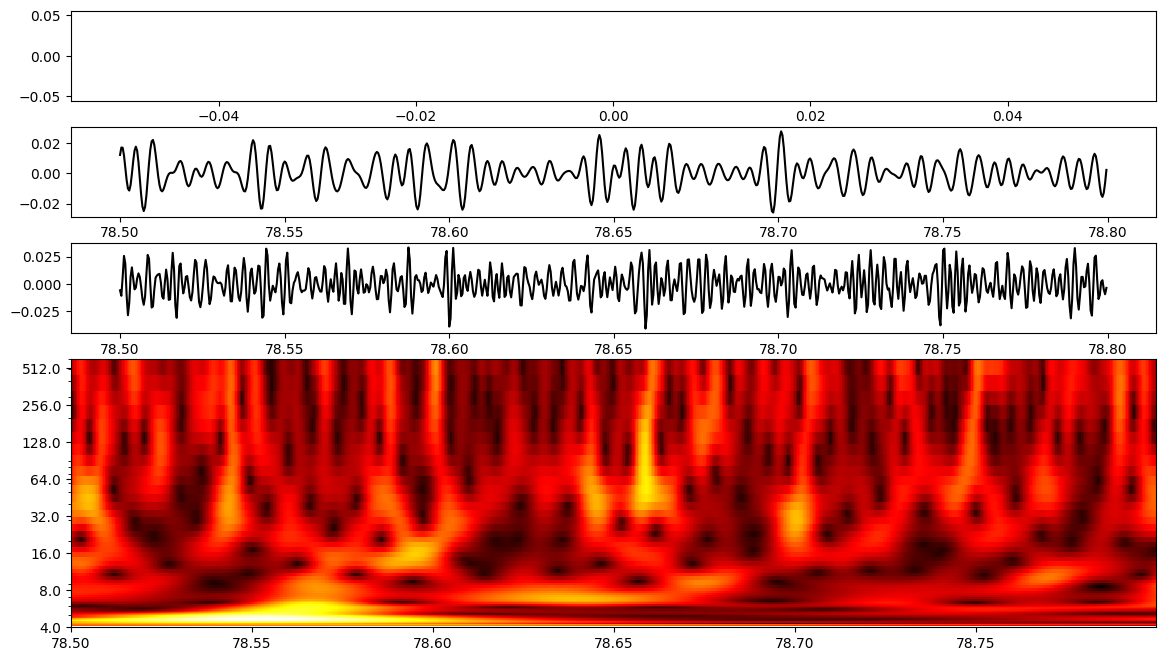

In [7]:
############ TESTER ##################
f = '/content/rip_data/2023x07x27/2023x07x27_E4KI_F_P296_s1x2_0000.abf'


abf = pyabf.ABF(f)
blank_time=5
filtered = time_bands(abf,sweepNumber=0,channel=1,blank_time=blank_time,new_fs=2500)
trace = filtered['sharp_wave_band']['lfp']
time = filtered['time_1khz']
fs = filtered['fs']
start_stop=[78.5,78.80]
fig,ax=plt.subplots(4,1,figsize=[14,8],gridspec_kw={'height_ratios':[1,1,1,3]})
# _ = inspect_trace(filtered['sharp_wave_band']['lfp'],time,fs,start_stop=start_stop,spec_color='r',line_length=1.5,figax_prev=(fig,ax[0]))
# _ = inspect_trace(filtered['ripple_band']['lfp'],time,fs,start_stop=start_stop,spec_color='k',line_length=1.5,figax_prev=(fig,ax[1]))
# _ = inspect_trace(filtered['fast_ripple_band']['lfp'],time,fs,start_stop=start_stop,spec_color='k',line_length=1.5,figax_prev=(fig,ax[2]))


t_bool = np.logical_and(time>=start_stop[0],time<start_stop[-1])

ax[0].plot( time[t_bool],filtered['sharp_wave_band']['lfp'][t_bool],'k')
ax[1].plot( time[t_bool],filtered['ripple_band']['lfp'][t_bool],'k')
ax[2].plot( time[t_bool],filtered['fast_ripple_band']['lfp'][t_bool],'k')

cwt_results = quick_wavelet(filtered['wide_band']['lfp'],fs,top_freq=600,bottom_freq=4,num_freq_bins=80,log_freq=True)


ax[3].pcolorfast(time[t_bool],cwt_results['freqs'],cwt_results['cwt_z'][:,t_bool][:-1,:-1],cmap='hot')#,vmin=0.5,vmax=5
ax[3].set_yscale('log')
new_ticks = cwt_results['log_ticks']
print(new_ticks)
_ = ax[3].set_yticks(new_ticks,labels=[str(t) for t in new_ticks])

In [ ]:
def triggered_inds(trace,fs,sd_thresh= 3,min_dur_ms= 5,peak_wind_ms=20):
    ''' trigger on crossing'''
    trig_bool = z_trans(trace)>sd_thresh
    min_dur_tic = int(min_dur_ms*fs/1000)
    trig_bool = mov_mean(trig_bool,min_dur_tic)==1
    trigs = np.arange(len(trig_bool))[np.diff(trig_bool,prepend=0)==1]

    ''' allign peaks'''
    tick_range = peak_wind_ms/1000*fs
    peak_window_tics = np.arange(0,tick_range,dtype=int)
    trig_alligned = []
    max_tick = len(trace)
    for t in trigs:
        if (t+peak_window_tics[0])>=0 and (t+peak_window_tics[-1])<max_tick:
            sub_trace = trace[t+peak_window_tics]
            peak_tick = np.where(sub_trace==np.max(sub_trace))[0][0]
            trig_alligned.append(t+peak_tick-np.min(peak_window_tics))
    trig_alligned=np.array(trig_alligned)

    return trig_alligned


trace = filtered['ripple_band']['hilb_env']
trigs = triggered_inds(trace,fs,sd_thresh= 2,min_dur_ms= 10,peak_wind_ms=20)
print(len(trigs))



483


In [83]:
#### single abf run through #####

def _abf_analyze(f ,chan_list = ['ch_0','ch_1'], trig_bands = ['ripple_band','sharp_wave_band','slow_gamma_band']):
    abf = pyabf.ABF(f)
    trig_sub_dict = { b:{'trigs':[], 'trig_rate':np.nan} for b in trig_bands}
    trig_dict = dict([(ch,trig_sub_dict) for ch in chan_list])
    for ch in chan_list:
        filtered = time_bands(abf,sweepNumber=0,channel= chan_list.index(ch) ,blank_time=blank_time,new_fs=2500)
        for b in trig_bands:
            trace = filtered[b]['hilb_env']
            fs = filtered['fs']
            trigs = triggered_inds(trace,fs,min_dur_ms=10)
            trig_dict[ch][b]['trigs'] = trigs
            if len(trigs)>1: trig_rate = len(trigs)/((trigs[-1]-trigs[0])/fs)
            else: trig_rate= np.nan
            trig_dict[ch][b]['trig_rate'] = trig_rate
    return trig_dict


f_test = e4_79_good_list[0]
print(f_test)
trig_dict = _abf_analyze(f_test)
display(trig_dict)
# filtered = time_bands(abf,sweepNumber=0,channel= chan_list.index(ch),order=4 ,blank_time=blank_time,new_fs=2500)
# trace = filtered['sharp_wave_band']['lfp']
# time = filtered['time_1khz']
# fs = filtered['fs']
# # inspect_trace(trace,time,fs)
# print(np.mean(np.isnan(trace)))

/content/rip_data/2023x07x27/2023x07x27_E4KI_F_P296_s1x2_0000.abf


{'ch_0': {'ripple_band': {'trigs': array([ 431232, 1059192, 1563046, ..., 2530846, 3822938, 4738886]),
   'trig_rate': 0.005223260735425826},
  'sharp_wave_band': {'trigs': array([     12,   27831,   28823, ..., 4695016, 4708496, 4736477]),
   'trig_rate': 0.35838964290879377},
  'slow_gamma_band': {'trigs': array([     12,   28835,   34915, ..., 4691941, 4695001, 4736471]),
   'trig_rate': 0.38953150444245377}},
 'ch_1': {'ripple_band': {'trigs': array([ 431232, 1059192, 1563046, ..., 2530846, 3822938, 4738886]),
   'trig_rate': 0.005223260735425826},
  'sharp_wave_band': {'trigs': array([     12,   27831,   28823, ..., 4695016, 4708496, 4736477]),
   'trig_rate': 0.35838964290879377},
  'slow_gamma_band': {'trigs': array([     12,   28835,   34915, ..., 4691941, 4695001, 4736471]),
   'trig_rate': 0.38953150444245377}}}